In [1]:
import os

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

In [2]:
def simulator(parameter_set):
    return parameter_set + torch.randn(parameter_set.shape) * 0.1

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 195 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

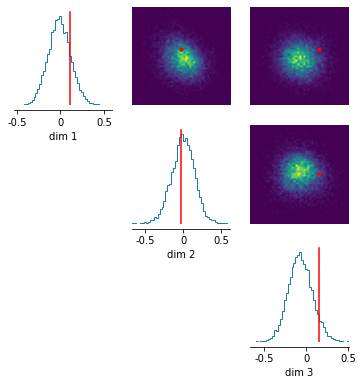

In [3]:
# data
prior = utils.BoxUniform(low=-2*torch.ones(3), high=2*torch.ones(3))
observation = torch.zeros(3)
x_o = simulator(observation)

# learning the density estimator and building the posterior
simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=500, num_workers=4)

# creating a posterior from neural density estimator
inference = SNPE(prior)
density_estimator = inference.append_simulations(theta, x).train()
og_posterior = inference.build_posterior(density_estimator)

# sampling from the posterior
samples = og_posterior.sample((10000,), x=observation)
log_probability = og_posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples,
                      figsize=(6, 6),
                      points=x_o,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])

# save the density estimator state dictionary
torch.save(og_posterior.net.state_dict(), os.path.join('output', 'psd.pth'))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

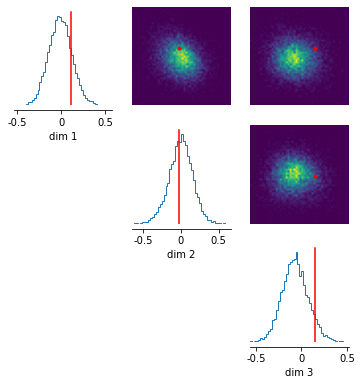

In [4]:
# build new "empty" posterior
new_posterior = inference.build_posterior()

# load the state dictionary
new_posterior.net.load_state_dict(torch.load(os.path.join('output', 'psd.pth')))

# sampling from the new posterior
samples = new_posterior.sample((10000,), x=observation)
log_probability = new_posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples,
                      figsize=(6, 6),
                      points=x_o,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])